### Predictive: What is likely to happen?

### Prescriptive: What do I need to do?



In [1]:
import pandas as pd
import seaborn as sns

## Load data from excel file

In [2]:
df = pd.read_excel('../data/Production Data Versaline.xlsx')
df = df.rename(columns={"Breakdowns and other delays": "BreakDowns", "Effective production time": "Eff Prod time"})
print(df.columns)
df.head(2)

Index(['Date', 'Product', 'Planned start Time', 'Actual Start Time',
       'Stop Time', 'Total time', 'Startup Delay', 'BreakDowns',
       'Eff Prod time', 'Operating Speed', 'Produced Qty', 'Rejects Qty',
       'Mix Usage', 'Mix Wastage', 'Mix yield', 'AR', 'PR', 'QR', 'OEE',
       'Mix Per Stick', 'Efficiency', 'Planned Qty'],
      dtype='object')


,Date,Product,Planned start Time,Actual Start Time,Stop Time,Total time,Startup Delay,BreakDowns,Eff Prod time,Operating Speed,...,Mix Usage,Mix Wastage,Mix yield,AR,PR,QR,OEE,Mix Per Stick,Efficiency,Planned Qty
0,2018-07-02,WB Chocolate,06:30:00,10:30:00,20:30:00,14.0,4.0,5.15,4.85,28880,...,7840.0,991.000,0.873597,0.346429,1.496754,0.873597,0.452976,0.0375,0.499675,NaN
1,2018-07-04,WB Vanilla,06:00:00,18:30:00,20:00:00,14.0,12.5,0.00,1.50,28880,...,1160.0,40.625,0.964978,0.107143,0.716049,0.964978,0.074033,0.0375,0.098710,NaN


### Calculate Rejects percentage and add as a colomn

Rejects percentage = Rejects Qty / Total Qty

In [3]:
# Add rejects percentage

def get_rejects_percentage(row):
    return row["Rejects Qty"]/(row["Produced Qty"]+row["Rejects Qty"])

df['Rejects Pct'] = df.apply (lambda row: get_rejects_percentage(row), axis=1)
# df.info()

In [4]:
# df2 = pd.read_excel('../data/Production Data Flexline.xlsx', sheet_name=1)
# print(df2.columns)
# df2.head(2)


AR - Avaliability Rate

PR - Perfromance Rate

QR - Quality Rate

OEE - Overall Equipment Efficiency (AR * PR * QR)

Product |
production Qty |
Breakdown time |
Rejects percentage |

## Select only the useful features
remove duplicate features such as start time and end time

In [5]:
useful_colomns = ["Product", "Produced Qty", "BreakDowns", 
                  "Startup Delay", "Total time", "Rejects Pct", "OEE"]
df = df[useful_colomns]

df.head(2)

,Product,Produced Qty,BreakDowns,Startup Delay,Total time,Rejects Pct,OEE
0,WB Chocolate,182640,5.15,4.0,14.0,0.126403,0.452976
1,WB Vanilla,29850,0.00,12.5,14.0,0.035022,0.074033


In [6]:
df.Product.unique()

array(['WB Chocolate', 'WB Vanilla', 'JJ Necto', 'MM Watermelon',
       'MM Orange', 'WB Chock Shock', 'WB Berry', '2-Bar Vanilla Faluda',
       'JJ Cream Soda', 'JJ Orange Crush ', 'Ice Cake', 'Bubble Gumy',
       'JJ Creamsoda', 'WB Vnilla', 'Bubble Gummy', 'Ice cake',
       'WB Chocok Shock', 'JJ Orange Crush'], dtype=object)

## Rename Duplicates products with the correct name

In [7]:
df = df.replace({'Product': {"JJ Orange Crush ": "JJ Orange Crush", 
                             "WB Chocok Shock": "WB Chock Shock",
                            "Ice cake": "Ice Cake",
                            "Bubble Gumy":"Bubble Gummy", 
                            "WB Vnilla": "WB Vanilla",
                            "JJ Creamsoda": "JJ Cream Soda"}})
for product in df.Product.unique():
    print("{:15} = {}".format(product, df[df["Product"] == product]["Product"].count()))

WB Chocolate    = 62
WB Vanilla      = 74
JJ Necto        = 45
MM Watermelon   = 51
MM Orange       = 65
WB Chock Shock  = 30
WB Berry        = 16
2-Bar Vanilla Faluda = 65
JJ Cream Soda   = 15
JJ Orange Crush = 8
Ice Cake        = 5
Bubble Gummy    = 5


In [8]:
print("Number of rows: {}".format(df.Product.count()))
df.info()


Number of rows: 441
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441 entries, 0 to 440
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Product        441 non-null    object 
 1   Produced Qty   441 non-null    int64  
 2   BreakDowns     441 non-null    float64
 3   Startup Delay  441 non-null    float64
 4   Total time     441 non-null    float64
 5   Rejects Pct    440 non-null    float64
 6   OEE            441 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 24.2+ KB


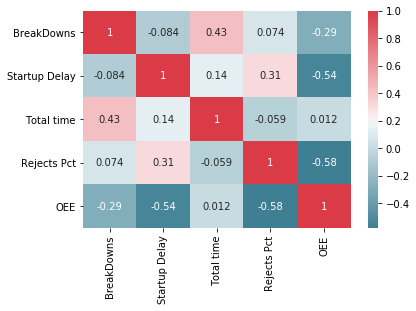

In [9]:
corr = df.loc[:,df.dtypes == 'float64'].corr()
# plt.figure(figsize=(10, 10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True)

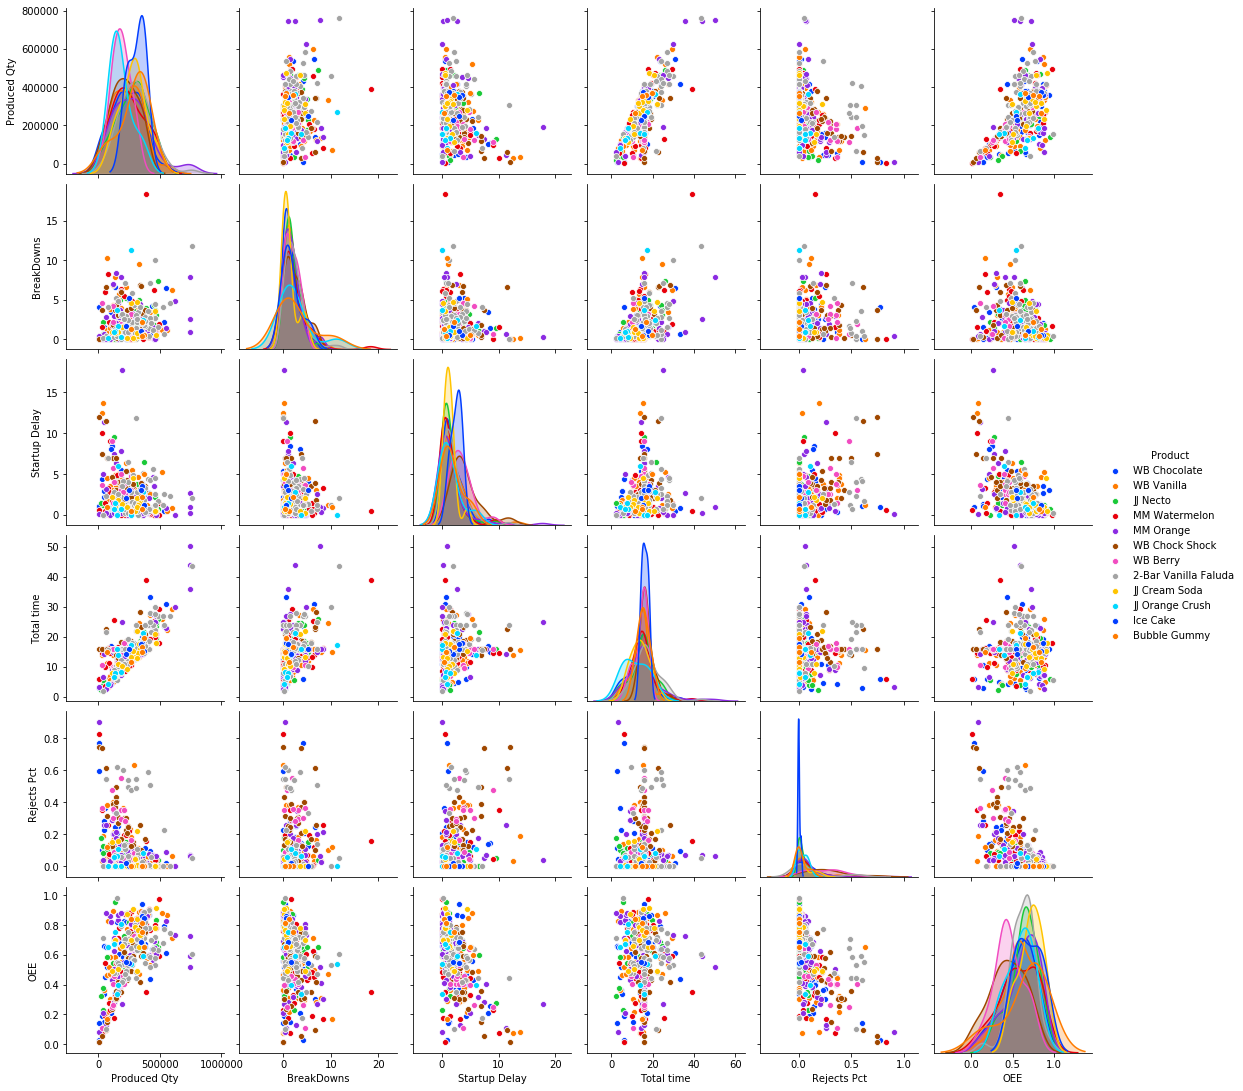

In [10]:
sns.pairplot(df, hue="Product", palette="bright")

## Fill the NAN values with the mean of the colomn

In [11]:
for val in ["Rejects Pct"]:#["Rejects Pct", "Mix yield"]
    df[val] = df[val].fillna(df[val].mean())
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441 entries, 0 to 440
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Product        441 non-null    object 
 1   Produced Qty   441 non-null    int64  
 2   BreakDowns     441 non-null    float64
 3   Startup Delay  441 non-null    float64
 4   Total time     441 non-null    float64
 5   Rejects Pct    441 non-null    float64
 6   OEE            441 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 24.2+ KB


In [12]:
group_by_products = df.groupby(by=['Product'])
product_data_avg = group_by_products.mean()
product_data_count = group_by_products.count()
# print(product_data_avg)
# print(product_data_count)

## Some plots using seaboarn
https://towardsdatascience.com/a-guide-to-pandas-and-matplotlib-for-data-exploration-56fad95f951c
    

In [13]:
# import seaborn as sns
# %matplotlib inline

# filtered_class = df[df['Product'] == 'WB Chocolate']
# sns.lmplot("OEE", "Rejects Pct", data=filtered_class, fit_reg=False, col='Product', col_wrap=2)

frames = [df[df["Mix yield"].isna()], df[df["Rejects Qty"].isna()]]
pd.concat(frames)

In [14]:
# from matplotlib.ticker import AutoMinorLocator
# import matplotlib.pyplot as plt

# fig = plt.figure(figsize=(18,6))

# ax1 = sns.violinplot('Product', "OEE", data=df)


# ax1.minorticks_on()
# ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
# ax1.grid(which='minor', axis='x', linewidth=1)

In [15]:
# sns.pairplot(df.loc[:,df.dtypes == 'float64'])

In [16]:
# corr = df.loc[:,df.dtypes == 'float64'].corr()
# sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True))

In [17]:
for col in df.columns.values:
    print("{:20} = {}".format(col, df[col].nunique()))

Product              = 12
Produced Qty         = 433
BreakDowns           = 261
Startup Delay        = 130
Total time           = 208
Rejects Pct          = 301
OEE                  = 439


## Here we test different regression methods

In [18]:
import numpy as np

In [19]:
def test_results(model, features, actual):
    y_pred = model.predict([features])
    print("Result: {}\nActual: {}".format(y_pred[0], actual))
    print("Error:{}\nSqured Error:{}".format(y_pred[0]-actual, (y_pred[0]-actual)**2))

### Data preperration

In [20]:
# Products as a input
df['Product'] = pd.Categorical(df['Product'])
dfDummies = pd.get_dummies(df['Product'], prefix = 'prod')
# dfDummies.info()
df_p = pd.concat([df, dfDummies], axis=1)
# df_p.info()

In [21]:
# Select only one product
# df_p = df[df['Product']=="WB Chocolate"]
# df_p = df[df['Product']=="MM Orange"]

In [22]:
# Scale the data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

y = df_p["OEE"]
X = df_p.drop(['Product', 'OEE'], axis = 1) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

def scale(dataframe, scaler=None):
    colomns_to_scale = ["Produced Qty", "BreakDowns", "Startup Delay", "Total time", "Rejects Pct"]
    # Only scale relevenat features
    scaled_features = dataframe.copy()
    features = scaled_features[colomns_to_scale]
    if scaler is None:
        scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    scaled_features[colomns_to_scale] = features
    return scaled_features, scaler

X_train_s, scaler = scale(X_train)
X_test_s, _ = scale(X_test, scaler)
# X_train_s.head()
# X_test_s.head()

### Linear Regression

In [23]:
from sklearn.linear_model import LinearRegression

regr = LinearRegression() 
regr.fit(X_train, y_train) 
y_pred = regr.predict(X_test)
print("Accuracy:", r2_score(y_test, y_pred))

Accuracy: 0.8448161466480698


### Decision Tree 

In [24]:
# y = df_p["OEE"]
# X = df_p.drop(['Product', 'OEE'], axis = 1) 

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [25]:
# Hyper parameter Tuning for Decision Trees

from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# Number of features to consider at every split
criterion = ["mse", "friedman_mse", "mae"]
splitter = ["best", "random"]
max_features = ['auto', 'log2', 'sqrt']
max_features.append(None)
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]  # Create the random grid
random_grid = {'criterion': criterion,
               'splitter': splitter,
                'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
pprint(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = DecisionTreeRegressor()
print(rf.get_params().keys())
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2,
                               random_state=42, n_jobs=-1)  # Fit the random search model
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)

{'criterion': ['mse', 'friedman_mse', 'mae'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'log2', 'sqrt', None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'splitter': ['best', 'random']}
dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s


{'splitter': 'best', 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 50, 'criterion': 'mae'}


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.3s finished


In [40]:
regressor = DecisionTreeRegressor(splitter="best", criterion="mae", random_state=0, min_samples_split=5, 
                                  min_samples_leaf=2, max_features=None, max_depth=50)
# regressor = DecisionTreeRegressor(random_state=0)
print(regressor.fit(X_train,y_train))

y_pred = regressor.predict(X_test)
print("Accuracy:", r2_score(y_test, y_pred))

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=50,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')
Accuracy: 0.8343317707950609


In [27]:
number = 2
test_results(regressor, X_test.iloc[number], y_test.iloc[number])
# y_pred = regressor.predict([X.loc[number]])
# print("Features: {}\nResult: {}".format(X.loc[number], y_pred))

Result: 0.3155009972885455
Actual: 0.355357142857143
Error:-0.039856145568597456
Squred Error:0.0015885123395852306


### Plotting the tree

In [28]:
# from sklearn import tree
# t = tree.plot_tree(regressor)

['Produced Qty', 'BreakDowns', 'Startup Delay', 'Total time', 'Rejects Pct', 'prod_2-Bar Vanilla Faluda', 'prod_Bubble Gummy', 'prod_Ice Cake', 'prod_JJ Cream Soda', 'prod_JJ Necto', 'prod_JJ Orange Crush', 'prod_MM Orange', 'prod_MM Watermelon', 'prod_WB Berry', 'prod_WB Chock Shock', 'prod_WB Chocolate', 'prod_WB Vanilla']


/home/dulanj/Environments/py376/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


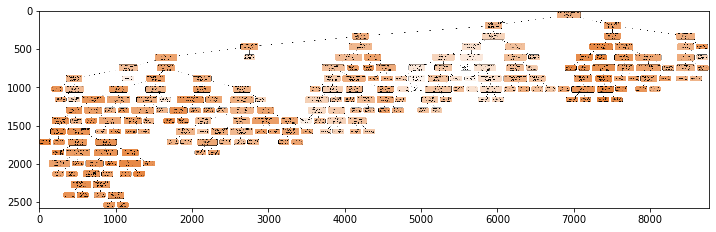

In [36]:
import matplotlib.pyplot as plt
import pydotplus
import matplotlib.image as mpimg
import io

from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz

dot_data = io.StringIO()

plot_colomns = list(df_p.columns)
plot_colomns.remove('OEE')
plot_colomns.remove('Product')
print(plot_colomns)
export_graphviz(regressor, out_file=dot_data, feature_names=plot_colomns, class_names=["OEE"], rounded=True, filled=True)

filename = "Decision_Tree.png"
pydotplus.graph_from_dot_data(dot_data.getvalue()).write_png(filename)

plt.figure(figsize=(12,12))
img = mpimg.imread(filename)
imgplot = plt.imshow(img)

plt.show()

### Scaling the data

## Support Vector Machine

In [30]:
from sklearn.svm import SVR

svm_classifier = SVR(kernel='linear')         
svm_classifier.fit(X_train_s, y_train)
y_pred = svm_classifier.predict(X_test_s)

print("Accuracy:", r2_score(y_test, y_pred))

Accuracy: 0.804315810116353


### Random Forest

In [31]:
from sklearn.ensemble import RandomForestRegressor

In [32]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=10)]
# Number of features to consider at every split
criterion = ["mse", "mae"]
max_features = ['auto', 'log2', 'sqrt']
max_features.append(None)
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]  # Create the random grid
random_grid = {'n_estimators': n_estimators,
                'criterion': criterion,
                'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
pprint(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
print(rf.get_params().keys())
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2,
                               random_state=42, n_jobs=-1)  # Fit the random search model
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'criterion': ['mse', 'mae'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'log2', 'sqrt', None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}
dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.3min finished


{'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'criterion': 'mae'}


In [44]:
# random_forest_regressor = RandomForestRegressor(n_estimators=100, random_state=0)
random_forest_regressor = RandomForestRegressor(n_estimators=800, criterion='mae', max_features='auto', max_depth=80, 
                                                min_samples_split=5, min_samples_leaf=1, random_state=0)

random_forest_regressor.fit(X_train_s, y_train)
y_pred_t = random_forest_regressor.predict(X_test_s)
print("Accuracy:", r2_score(y_test, y_pred_t))

Accuracy: 0.8866850503660298


### Neural network

Input Dimention: 17
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
DenseLayer-1 (Dense)         (None, 192)               3456      
_________________________________________________________________
DenseLayer-2 (Dense)         (None, 64)                12352     
_________________________________________________________________
DenseLayer-3 (Dense)         (None, 16)                1040      
_________________________________________________________________
DenseLayer-4 (Dense)         (None, 1)                 17        
Total params: 16,865
Trainable params: 16,865
Non-trainable params: 0
_________________________________________________________________
None
Train on 246 samples, validate on 62 samples
Epoch 1/100
246/246 [==============================] - 0s 484us/step - loss: 0.2660 - mean_absolute_error: 0.2660 - val_loss: 0.1232 - val_mean_absolute_error: 0.1232
Epoch 2/100

Epoch 44/100
246/246 [==============================] - 0s 101us/step - loss: 0.0201 - mean_absolute_error: 0.0201 - val_loss: 0.0364 - val_mean_absolute_error: 0.0364
Epoch 45/100
246/246 [==============================] - 0s 86us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - val_loss: 0.0313 - val_mean_absolute_error: 0.0313
Epoch 46/100
246/246 [==============================] - 0s 88us/step - loss: 0.0234 - mean_absolute_error: 0.0234 - val_loss: 0.0326 - val_mean_absolute_error: 0.0326
Epoch 47/100
246/246 [==============================] - 0s 86us/step - loss: 0.0226 - mean_absolute_error: 0.0226 - val_loss: 0.0310 - val_mean_absolute_error: 0.0310
Epoch 48/100
246/246 [==============================] - 0s 88us/step - loss: 0.0200 - mean_absolute_error: 0.0200 - val_loss: 0.0334 - val_mean_absolute_error: 0.0334
Epoch 49/100
246/246 [==============================] - 0s 90us/step - loss: 0.0178 - mean_absolute_error: 0.0178 - val_loss: 0.0322 - val_mean_absolute_error: 0.03

246/246 [==============================] - 0s 99us/step - loss: 0.0156 - mean_absolute_error: 0.0156 - val_loss: 0.0291 - val_mean_absolute_error: 0.0291
Epoch 94/100
246/246 [==============================] - 0s 87us/step - loss: 0.0174 - mean_absolute_error: 0.0174 - val_loss: 0.0405 - val_mean_absolute_error: 0.0405
Epoch 95/100
246/246 [==============================] - 0s 91us/step - loss: 0.0182 - mean_absolute_error: 0.0182 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 96/100
246/246 [==============================] - 0s 83us/step - loss: 0.0142 - mean_absolute_error: 0.0142 - val_loss: 0.0344 - val_mean_absolute_error: 0.0344
Epoch 97/100
246/246 [==============================] - 0s 90us/step - loss: 0.0149 - mean_absolute_error: 0.0149 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 98/100
246/246 [==============================] - 0s 93us/step - loss: 0.0139 - mean_absolute_error: 0.0139 - val_loss: 0.0315 - val_mean_absolute_error: 0.0315
Epoch 99/10

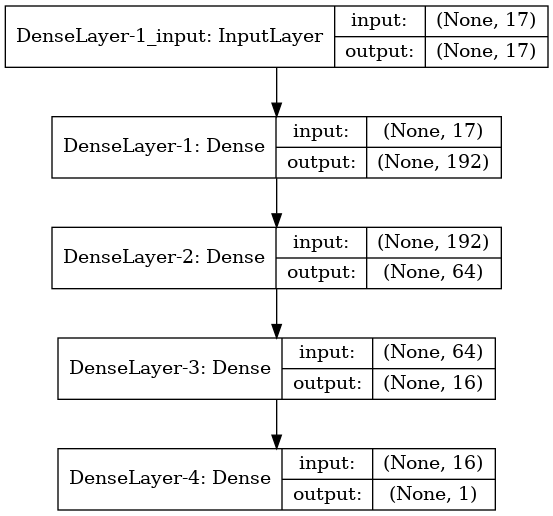

In [41]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
input_dim = len(X_train_s.columns)
model.add(Dense(192, input_dim=input_dim, activation='relu', name="DenseLayer-1"))
model.add(Dense(64, activation='relu', name="DenseLayer-2"))
model.add(Dense(16, activation='relu', name="DenseLayer-3"))
model.add(Dense(1, activation='linear', name="DenseLayer-4"))
print("Input Dimention: {}".format(input_dim))
print(model.summary())

# compile the keras model
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

model.fit(X_train_s, y_train, epochs=100, batch_size=10, verbose=1, validation_split=0.2)

y_pred = model.predict(X_test_s)
print("Accuracy:", r2_score(y_test, y_pred))

# SAve model as image
from keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True)

In [35]:
number = 3
test_results(regressor, X_test_s.iloc[number], y_test.iloc[number])

Result: 0.19831629424498853
Actual: 0.590192043896313
Error:-0.39187574965132443
Squred Error:0.1535666031647875
